In [ ]:
import os
import pandas as pd
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/ETH-USD.csv",
                  parse_dates=["Date"],
                  index_col=["Date"])
eth_prices = pd.DataFrame(df['Close'])

In [ ]:
eth_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2160 entries, 2017-11-09 to 2023-10-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2160 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB


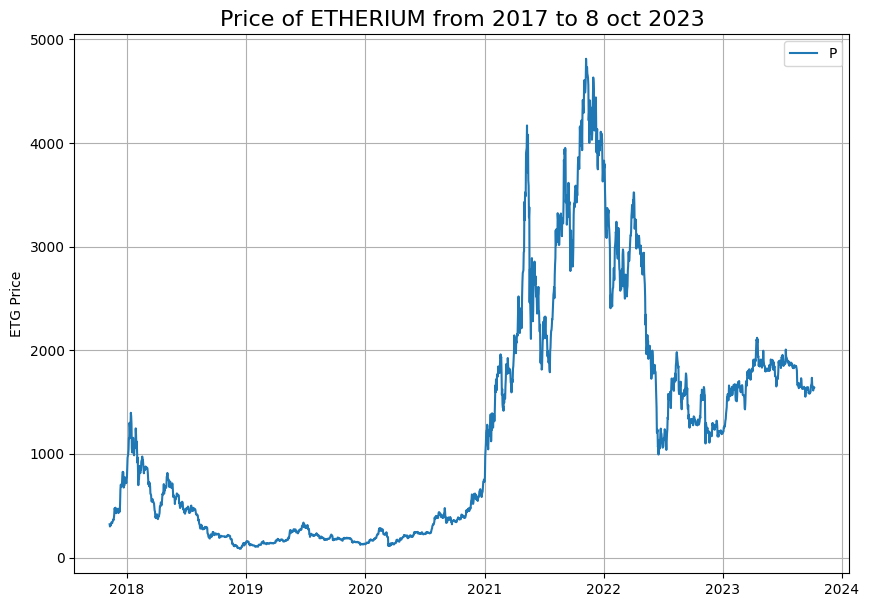

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.plot(eth_prices)
plt.ylabel("ETG Price")
plt.title("Price of ETHEREUM from 2017 to 8 oct 2023", fontsize=16)
plt.legend('Prices')

plt.grid(True)
plt.show()

In [ ]:
timesteps = eth_prices.index.to_numpy()
prices = eth_prices['Close'].to_numpy()
timesteps[:10], prices[:10]

(array(['2017-11-09T00:00:00.000000000', '2017-11-10T00:00:00.000000000',
        '2017-11-11T00:00:00.000000000', '2017-11-12T00:00:00.000000000',
        '2017-11-13T00:00:00.000000000', '2017-11-14T00:00:00.000000000',
        '2017-11-15T00:00:00.000000000', '2017-11-16T00:00:00.000000000',
        '2017-11-17T00:00:00.000000000', '2017-11-18T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([320.884003, 299.252991, 314.681   , 307.90799 , 316.716003,
        337.631012, 333.356995, 330.924011, 332.394012, 347.612   ]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=None, shuffle=False)

In [ ]:
X_train.shape, X_test.shape, y_train.shape

((1728,), (432,), (1728,))

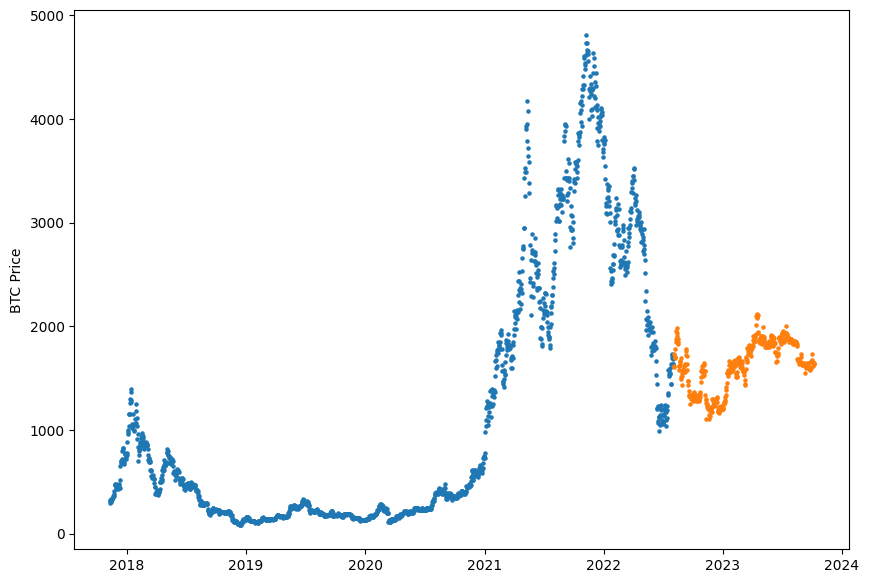

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5)
plt.scatter(X_test, y_test, s=5)
plt.ylabel('BTC Price')
plt.show();

In [ ]:
naive_forecast = naive_forecast = y_test[:-1]

In [ ]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("ETH Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [ ]:
import tensorflow as tf

# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  '''
  Implement MASE (assuming no seasonality of data).
  '''
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find mae of naive forecast (no seasonality)

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]- y_true[:-1])) # our seasonality is 1day (hence the shift of 1)
  return mae / mae_naive_no_season



In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.metrics import mean_absolute_percentage_error
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  if mae.ndim >0:
    mae=tf.reduce_mean(mae)
    mse=tf.reduce_mean(mse)
    rmse=tf.reduce_mean(rmse)
    mape=tf.reduce_mean(mape)
    mase=tf.reduce_mean(mase)

  return {'mae' : mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape' : mape.numpy(),
          'mase' : mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results


{'mae': 32.856106,
 'mse': 2398.9712,
 'rmse': 48.979294,
 'mape': 2.0722709,
 'mase': 0.99843216}

In [ ]:
# Let's setup global variables for window and horizon size

HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction

In [ ]:
import numpy as np

def create_windowed_dataset(x, window_size=WINDOW_SIZE, horizon=HORIZON, axis=0):
  '''
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7]
  Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  '''
  # 1. Create a window of specific window_size (add the horizon on the end for labeling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

  # 2. Index on the target array (a time series) with the 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 3. Get the labeled windows
  windows, labels = windowed_array[:, :-horizon], windowed_array[:, -horizon:]

  return windows, labels

full_windows, full_labels = create_windowed_dataset(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# View the first 3 windows/labels
for i in range(3):
  print(f'window: {full_windows[i]}-> Label{full_labels[i]}')


window: [320.884003 299.252991 314.681    307.90799  316.716003 337.631012
 333.356995]-> Label[330.924011]
window: [299.252991 314.681    307.90799  316.716003 337.631012 333.356995
 330.924011]-> Label[332.394012]
window: [314.681    307.90799  316.716003 337.631012 333.356995 330.924011
 332.394012]-> Label[347.612]


In [ ]:
prices[-1]

1638.000244

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  '''
  Splits matchin pairs of windows and labels into train and test splits.
  '''
  split_size = int(len(windows) * (1-test_split)) # This will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, train_labels, test_windows, test_labels

train_windows, train_labels, test_windows, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1722, 431, 1722, 431)

In [ ]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            monitor='val_loss',
                                            save_best_only=True)

In [ ]:
# Model_1 Dense (window = 7, horizon = 1)

import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)
# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

history_1 = model_1.fit(train_windows, train_labels, epochs=100, validation_data=(test_windows, test_labels), batch_size=32, callbacks=[create_model_checkpoint(model_name='model_1')])

Epoch 1/100
54/54 [==============================] - 5s 17ms/step - loss: 438.5050 - mae: 438.5050 - mse: 964531.4375 - val_loss: 81.4172 - val_mae: 81.4172 - val_mse: 9919.3994
Epoch 2/100
54/54 [==============================] - 1s 11ms/step - loss: 60.7061 - mae: 60.7061 - mse: 12457.1338 - val_loss: 47.1785 - val_mae: 47.1785 - val_mse: 4308.3623
Epoch 3/100
54/54 [==============================] - 1s 10ms/step - loss: 55.0920 - mae: 55.0920 - mse: 10892.2744 - val_loss: 40.9268 - val_mae: 40.9268 - val_mse: 3549.9841
Epoch 4/100
54/54 [==============================] - 1s 11ms/step - loss: 53.3748 - mae: 53.3748 - mse: 9957.7354 - val_loss: 39.1922 - val_mae: 39.1922 - val_mse: 3257.4463
Epoch 5/100
54/54 [==============================] - 0s 4ms/step - loss: 52.6291 - mae: 52.6291 - mse: 10039.9941 - val_loss: 68.6577 - val_mae: 68.6577 - val_mse: 6531.5884
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 49.7830 - mae: 49.7830 - mse: 9086.7920 - val_loss

In [ ]:
# Evaluate on 100 epochs
model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 8ms/step - loss: 44.6418 - mae: 44.6418 - mse: 3352.2405


[44.64177703857422, 44.64177703857422, 3352.240478515625]

In [ ]:
# Evaluate on best epoch during training
model_1 = tf.keras.models.load_model('/content/model_experiments/model_1')

In [ ]:
model_1_pred_probs = model_1.evaluate(test_windows, test_labels)

14/14 [==============================] - 1s 8ms/step - loss: 32.5302 - mae: 32.5302 - mse: 2400.9409


In [ ]:
def make_preds(model, input_data):
  '''
  Uses model to make predictions input_data.
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)

# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)

14/14 [==============================] - 0s 5ms/step


In [ ]:
model_1_results

{'mae': 32.530163,
 'mse': 2400.9407,
 'rmse': 48.999393,
 'mape': 2.057124,
 'mase': 0.9885274}

In [ ]:
naive_results

{'mae': 32.856106,
 'mse': 2398.9712,
 'rmse': 48.979294,
 'mape': 2.0722709,
 'mase': 0.99843216}

In [ ]:
input = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='relu'))(x)
x = layers.LSTM(128, activation='relu')(x)
output = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=input, outputs=output)

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

history_5 = model_5.fit(train_windows, train_labels, epochs=100, batch_size=128, validation_data=(test_windows, test_labels), callbacks=[create_model_checkpoint(model_name='model_5')])

Epoch 1/100
14/14 [==============================] - 12s 537ms/step - loss: 947.5428 - val_loss: 1004.6204
Epoch 2/100
14/14 [==============================] - 5s 375ms/step - loss: 352.0381 - val_loss: 235.7399
Epoch 3/100
14/14 [==============================] - 5s 385ms/step - loss: 124.2864 - val_loss: 140.4422
Epoch 4/100
14/14 [==============================] - 6s 432ms/step - loss: 86.2274 - val_loss: 52.9012
Epoch 5/100
14/14 [==============================] - 0s 16ms/step - loss: 62.1647 - val_loss: 67.5849
Epoch 6/100
14/14 [==============================] - 5s 394ms/step - loss: 60.0314 - val_loss: 49.2379
Epoch 7/100
14/14 [==============================] - 0s 15ms/step - loss: 59.4443 - val_loss: 49.5644
Epoch 8/100
14/14 [==============================] - 0s 16ms/step - loss: 59.8244 - val_loss: 57.8417
Epoch 9/100
14/14 [==============================] - 0s 14ms/step - loss: 60.0662 - val_loss: 70.2797
Epoch 10/100
14/14 [==============================] - 0s 14ms/step - 